In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
images = []
ages = []
genders = []

for i in os.listdir('../input/utkface-new/UTKFace/')[0:4000]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(Image.open('../input/utkface-new/UTKFace/' + i))

In [3]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')

df = pd.concat([images, ages, genders], axis=1)
df

,Images,Ages,Genders
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,26,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,22,1
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,21,1
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,28,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,17,1
...,...,...,...
3995,<PIL.JpegImagePlugin.JpegImageFile image mode=...,34,0
3996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,45,1
3997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,22,1
3998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,26,0


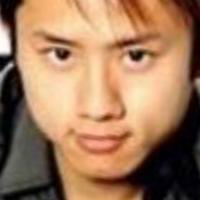

26 0


In [4]:
display(df['Images'][0])
print(df['Ages'][0], df['Genders'][0])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Ages', ylabel='Density'>

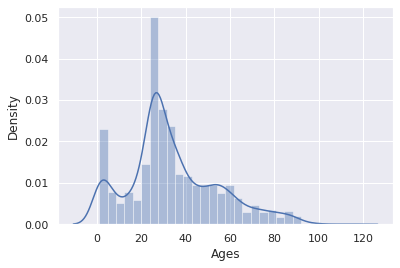

In [5]:
sns.set_theme()
sns.distplot(df['Ages'], bins=30)

In [6]:
len(df)

4000

In [7]:
x = []
y = []

for i in range(len(df)):
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.ANTIALIAS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i])]
    y.append(agegen)
x = np.array(x)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [8]:
y_age = df['Ages'] // 20
y_age = to_categorical(y_age, num_classes=6)

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2)

In [9]:
datagen = ImageDataGenerator(
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2, 
    horizontal_flip = True) 

In [10]:
from keras.applications.vgg16 import VGG16


base_model_vgg16 = VGG16(
    weights = 'imagenet',  
    input_shape=(200, 200, 3),
    include_top=False) 
for layer in base_model_vgg16.layers:
    layer.trainable = False
    
model_vgg16 = Sequential()
model_vgg16.add(base_model_vgg16)
model_vgg16.add(Flatten())
model_vgg16.add(Dense(6,activation='softmax'))
model_vgg16.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 6)                 110598    
Total params: 14,825,286
Trainable params: 110,598
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
model_vgg16.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", "mae"])

history_vgg16 = model_vgg16.fit_generator(datagen.flow(x_train_age, y_train_age, batch_size=32),
                   epochs=10,
                   verbose=1,
                   validation_data=(x_test_age, y_test_age))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
100/100 [==============================] - 36s 321ms/step - loss: 11.8945 - accuracy: 0.5255 - mae: 0.1594 - val_loss: 7.1056 - val_accuracy: 0.5850 - val_mae: 0.1379
Epoch 2/10
100/100 [==============================] - 32s 318ms/step - loss: 5.7564 - accuracy: 0.6684 - mae: 0.1112 - val_loss: 7.1032 - val_accuracy: 0.6388 - val_mae: 0.1202
Epoch 3/10
100/100 [==============================] - 32s 318ms/step - loss: 4.9880 - accuracy: 0.7236 - mae: 0.0919 - val_loss: 7.3619 - val_accuracy: 0.6425 - val_mae: 0.1217
Epoch 4/10
100/100 [==============================] - 32s 316ms/step - loss: 4.7587 - accuracy: 0.7412 - mae: 0.0860 - val_loss: 8.2439 - val_accuracy: 0.6625 - val_mae: 0.1127
Epoch 5/10
100/100 [==============================] - 32s 319ms/step - loss: 4.1677 - accuracy: 0.7608 - mae: 0.0798 - val_loss: 9.0443 - val_accuracy: 0.6237 - val_mae: 0.1252
Epoch 6/10
100/100 [==============================] - 32s 317ms/step - loss: 3.6647 - accuracy: 0.7905 - mae: 0.07